In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
from netCDF4 import Dataset
from cartopy.util import add_cyclic_point

import numpy as np
from pathlib import Path

Get bioenergy from file for year 2050 which is index: 11.0
(96, 192)


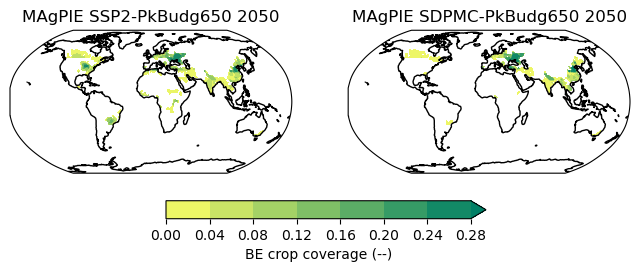

In [2]:
#
# MAKE A QUICK PLOT OF THE BIOENERGY CROP COVERAGE FROM THE MAGPIE SCENARIOS
#
ncfile3=Dataset('/bdd/ESM2025/WP10/IAM_BE_scenarions/JSBACH_SHAPE-SSP2-PkBudg650_MAgPIE_landareashare.nc','r')    
beyears = ncfile3.variables['time']
betime=(2050-beyears[0])/(beyears[1]-beyears[0])
print('Get bioenergy from file for year',beyears[int(betime)],'which is index:',betime)
bemask_minconst = ncfile3.variables['becrops'][betime,]

print(bemask_minconst.shape)
ncfile3=Dataset('/bdd/ESM2025/WP10/IAM_BE_scenarions/JSBACH_SHAPE-SDPMC-PkBudg650_MAgPIE_landareashare.nc','r')    
bemask_sustconst = ncfile3.variables['becrops'][betime,]
lons=ncfile3.variables['lon']
lats=ncfile3.variables['lat']

fig,axes=plt.subplots(ncols=2,
                      subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                      figsize=(8,6))       
pltname='/bdd/ESM2025/WP10/maps/magpie_becrops_2050.png'

bemask_minconst = np.ma.masked_less(bemask_minconst, 1.0e-9)

cs=axes[0].contourf(lons[:],lats[:],bemask_minconst, 
                      transform = ccrs.PlateCarree(central_longitude=0),
                      cmap='summer_r',extend='max')              
axes[0].set_title('MAgPIE SSP2-PkBudg650 2050')
axes[0].coastlines()

bemask_sustconst = np.ma.masked_less(bemask_sustconst, 1.0e-9)

cs=axes[1].contourf(lons[:],lats[:],bemask_sustconst, 
                      transform = ccrs.PlateCarree(central_longitude=0),
                      cmap='summer_r',extend='max')              
axes[1].set_title('MAgPIE SDPMC-PkBudg650 2050')
axes[1].coastlines()

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.32, 0.30, 0.4, 0.03])
# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',
                  label='BE crop coverage (--)' )

plt.savefig(pltname,format="png", dpi=400)


In [4]:
def get_lsm_data(lsm):
    """
    Returns a map of the land fraction in each grid cell (ie land_fraction<1 along coastal areas,
    although JSBACH has only 0s and 1s for this), and the latitudes and longitudes.
    """
    if lsm=='jules':
        ncfile1 = Dataset('/bdd/ESM2025/WP10/analysis/scripts/mask_latlon2d.nc', 'r')
        lons = ncfile1.variables['lon']
        lats = ncfile1.variables['lat']
        temparray = ncfile1.variables['land_sea_mask']
        
        land_fraction=np.empty_like(temparray)
        land_fraction[:,:90] = temparray[:,90:]
        land_fraction[:,90:] = temparray[:,:90]
        del(temparray)        
    elif lsm=='clm':
        ncfile1 = Dataset('/bdd/ESM2025/WP10/analysis/scripts/clm_landfrac.nc', 'r')
        lons = ncfile1.variables['lon']
        lats = ncfile1.variables['lat']
        land_fraction = ncfile1.variables['landfrac']
    elif lsm=='orchidee':
        ncfile1 = Dataset('/bdd/ESM2025/WP10/analysis/scripts/orchidee_oceanCoverFrac_notime.nc', 'r')
        lons = ncfile1.variables['longitude']
        lats = ncfile1.variables['latitude']
        #0=ocean; 1=land
        ocean_frac = ncfile1.variables['oceanCoverFrac']
        ones = np.ones_like(ocean_frac)
        land_fraction = ones - ocean_frac        
        del(ones, ocean_frac)
    elif lsm=='jsbach':
        ncfile1 = Dataset('/bdd/ESM2025/WP10/jsbach/hist/JSBACH3_ukesm1-0-ll_hist_hist_oceanCoverFrac.once.nc', 'r')
        lons = ncfile1.variables['lon']
        lats = ncfile1.variables['lat']
        #lats=np.flip(lats,0)
            
        #0=ocean; 1=land
        ocean_frac = ncfile1.variables['oceanCoverFrac']
        ones = np.ones_like(ocean_frac)
        land_fraction = ones - ocean_frac  
        del(ones, ocean_frac)
    else:
        print('Incorrect name for LSM in get_lsm_data')

    return land_fraction, lons, lats

In [5]:
def mask_between_threshold(cube, threshold):
    """Mask values between +/- a specific threshold value.

    Takes a value 'threshold' and masks off anything that is above
    it in the cube data. Values equal to the threshold are not masked.

    Parameters
    ----------
    cube: iris.cube.Cube
        iris cube to be thresholded.

    threshold: float
        threshold to be applied on input cube data.

    Returns
    -------
    iris.cube.Cube
        thresholded cube.
    """
    negative_threshold = -1 * threshold
    cube = np.ma.masked_inside(cube, negative_threshold, threshold)
    return cube

In [6]:
def make_map(lsm,label,axs,axi,lon,lats,input_array): 
    """
    Make the map of the input array.

    Inputs:
    lsm: Name of the land surface model.
    label: The land use scenario.
    axs: The axis for plotting.
    Axi: Index of the axis.
    lons: Longitude, should be len N
    lats: Latitudes, should be len M
    input_array: Data array, should be size (M,N)
    """
    
    mapdata,lons = add_cyclic_point(input_array,lon)
    
    colormap='summer_r'
           
    if lsm=='jsbach':
        clon=0.0
    elif lsm=='jules':
        clon=180.
    elif lsm=='clm':
        clon=0.0
    elif lsm=='orchidee':
        clon=0.0   
    
    mapdata = np.ma.masked_less(mapdata, 1.0e-9)

    #print(lsm,label,np.min(mapdata),np.max(mapdata))

    clevs=np.arange(2.0,24.0,2.0)

    cs=axs[axi].contourf(lons,lats,mapdata,clevs, 
                      transform = ccrs.PlateCarree(central_longitude=clon),
                      cmap=colormap,extend='max')              
    axs[axi].set_title(lsm+' '+label)
    axs[axi].coastlines()

    return cs

In [7]:
def jules_harvest(LU_SCENARIO,varname,ssp,ESMS,endyear,mask_value,be_threshold):

    """
    Return a map of JULES bioenergy yields.

    Inputs:
    LU_SCENARIO: the landuse scenario.
    varname: variable name for bioenergy harvests
    ssp: SSP scenario
    ESMS: list of the 3 ESM models used for the climate inputs
    endyear: The year that will be mapped.
    mask_value: 0 no mask
             1 Minimal constraints on bioenergy (from Remind-MagPIE)
             2 Sustainability constraints on bioenergy (from Remind-MagPIE)
    be_threshold: Ignore harvest where MagPIE fracs are small/non-existent.

    Returns:
    HARVEST_PLOT for this LSM, landuse scenario, and SSP (averaged across the 3 ESM climates)
            = np.mean(plotdata,axis=0)
    HARVEST_MAP for this LSM, landuse scenario, and SSP (averaged across the 3 ESM climates) for endyear
            = np.mean(harvest_annual_map[1,],axis=(0))
    """
    
    # Convert from kgC/m2/360d to tC/ha/yr
    constant_val=10*360/365/12

    # Dimensions
    land_fraction, lons, lats = get_lsm_data('jules')
    nlon = len(lons)
    nlat = len(lats)
    years = np.arange(2015,2101)
    ntime = len(years)
    
    # Weights are used to adjust for different sized gridcells from equator to poles
    weights = np.empty([ntime,nlat,nlon])
    for kk in range(nlat):
        weights[:,kk,:] = np.cos(np.deg2rad(lats[kk]))    

    if mask_value==1:
        ncfile3=Dataset('/bdd/ESM2025/WP10/IAM_BE_scenarions/JULES_SHAPE-SSP2-PkBudg650_MAgPIE_landareashare.nc','r')    
        beyears = ncfile3.variables['time']
        betime=(2050-beyears[0])/(beyears[1]-beyears[0])
        bemask = ncfile3.variables['becrops'][betime,]
        bemask_3d = np.stack([bemask] * ntime * 12)
    elif mask_value==2:
        ncfile3=Dataset('/bdd/ESM2025/WP10/IAM_BE_scenarions/JULES_SHAPE-SDPMC-PkBudg650_MAgPIE_landareashare.nc','r')    
        beyears = ncfile3.variables['time']
        betime=(2050-beyears[0])/(beyears[1]-beyears[0])
        bemask = ncfile3.variables['becrops'][betime,]
        bemask_3d = np.stack([bemask] * ntime * 12)
    
    # Set up arrays for storing the maps
    plotdata = np.empty([3,ntime])
    harvest_annual_map = np.empty([2,3,nlat,nlon])

    # Loop through the ESMs
    model_i=0
    for esm in ESMS:    
        ncfile2=Dataset('/bdd/ESM2025/WP10/jules/jules_'+esm+'_'+ssp+'_'+LU_SCENARIO+\
                        '_'+varname+'.monthly.nc', 'r')
        #print('/bdd/ESM2025/WP10/jules/jules_'+esm+'_'+ssp+'_'+LU_SCENARIO+\
        #                '_'+varname+'.monthly.nc')

        # JULES only has a value in January of each year, when the harvest occurs.
        harvest = ncfile2.variables['fBioHarvestpft'][0::12,13,:,:]

        # Ignore harvest in locations where crops fractional coverage is less than threshold value
        threshold = 0.0001
        fFile_scenario='/bdd/ESM2025/WP10/jules/jules_'+esm+'_'+ssp+'_'+\
                               LU_SCENARIO+'_landCoverFrac.monthly.nc'
        fFile_noluc='/bdd/ESM2025/WP10/jules/jules_'+esm+'_'+ssp+\
                               '_nolucbio_landCoverFrac.monthly.nc'    
        ncfile_scenario=Dataset(fFile_scenario, 'r')
        ncfile_noluc=Dataset(fFile_noluc, 'r')
        fracs_scenario = ncfile_scenario.variables['landCoverFrac'][0::12,13,:,:]
        fracs_noluc = ncfile_noluc.variables['landCoverFrac'][0::12,13,:,:]
        diff=fracs_scenario-fracs_noluc                        
        
        harvest = np.ma.masked_where(diff < threshold, harvest)

        # Ignore harvest where MagPIE fracs are small/non-existent 
        if mask_value>0:
            harvest = np.ma.masked_where(bemask_3d < be_threshold, harvest)
        del(fracs_noluc)
        del(fracs_scenario)
        del(diff)

        # Apply unit conversions
        harvest_annual_map[0,model_i,:,:] = harvest[0,]*constant_val
        iyear=endyear-2015
        harvest_annual_map[1,model_i,:,:] = harvest[iyear,]*constant_val

        plotdata[model_i,]=np.mean(harvest*weights,axis=(1,2))*constant_val

        model_i+=1

    if mask_value>0: del(bemask_3d,bemask)
    
    return np.mean(plotdata,axis=0),np.mean(harvest_annual_map[1,],axis=(0))

In [15]:
def jsbach_harvest(LU_SCENARIO,varname,ssp,ESMS,endyear,mask_value,be_threshold):

    """
    Return a map of JULES bioenergy yields.

    Inputs:
    LU_SCENARIO: the landuse scenario.
    varname: variable name for bioenergy harvests
    ssp: SSP scenario
    ESMS: list of the 3 ESM models used for the climate inputs
    endyear: The year that will be mapped (subtract 1 year if endyear=2100 for JSBACH)
    mask_value: 0 no mask
             1 Minimal constraints on bioenergy (from Remind-MagPIE)
             2 Sustainability constraints on bioenergy (from Remind-MagPIE)
    be_threshold: Ignore harvest where MagPIE fracs are small/non-existent.

    Returns:
    HARVEST_PLOT for this LSM, landuse scenario, and SSP (averaged across the 3 ESM climates)
            = np.mean(plotdata,axis=0)
    HARVEST_MAP for this LSM, landuse scenario, and SSP (averaged across the 3 ESM climates) for endyear
            = np.mean(harvest_annual_map[1,],axis=(0))
    """

    # Convert from kgC/m2 to tC/ha
    # The harvested carbon pool accumulates over time, so to calculate the annual harvests I calculated 
    # the difference between years (harvest_yr0 = cHbpharv_yr1 – cHbpharv_yr0 and so on). 
    constant_val = 10

    # Dimensions
    land_fraction, lons, lats = get_lsm_data('jsbach')
    nlon = len(lons)
    nlat = len(lats)
    years = np.arange(2015,2100)
    ntime = len(years)
    if endyear==2100: endyear-=1

    # Weights are used to adjust for different sized gridcells from equator to poles
    weights = np.empty([ntime*12,nlat,nlon])
    for kk in range(nlat):
        weights[:,kk,:] = np.cos(np.deg2rad(lats[kk]))    

    if mask_value==1:
        ncfile3=Dataset('/bdd/ESM2025/WP10/IAM_BE_scenarions/JSBACH_SHAPE-SSP2-PkBudg650_MAgPIE_landareashare.nc','r')    
        beyears = ncfile3.variables['time']
        betime=(2050-beyears[0])/(beyears[1]-beyears[0])
        bemask = ncfile3.variables['becrops'][betime,]
        bemask = np.flip(bemask_minconst,0)
        bemask_3d = np.stack([bemask] * ntime * 12)
    
    elif mask_value==2:
        ncfile4=Dataset('/bdd/ESM2025/WP10/IAM_BE_scenarions/JSBACH_SHAPE-SDPMC-PkBudg650_MAgPIE_landareashare.nc','r')    
        beyears = ncfile3.variables['time']
        betime=(2050-beyears[0])/(beyears[1]-beyears[0])
        bemask = ncfile4.variables['becrops'][betime,]
        bemask = np.flip(bemask_sustconst,0)
        bemask_3d = np.stack([bemask] * ntime * 12)


    # Set up arrays for storing the maps
    plotdata = np.empty([3,ntime])
    harvest_annual_map = np.empty([2,3,nlat,nlon])

    # Loop through the ESMs
    model_i=0
    for esm in ESMS:    
        ncfile2 = Dataset('/bdd/ESM2025/WP10/jsbach/'+LU_SCENARIO+'/'+\
                     'JSBACH3_'+esm+'_'+ssp+'_'+LU_SCENARIO+'_cHbpharv.monthly.nc','r')
        harvest = ncfile2.variables['cHbpharv'][:,:,:]

        # Following steps advised by Tobias:
        # The gridbox total harvest was calculated by multiplying harvests * frac in the model.
        # So to get a more accurate representation of harvests per unit area, we need to divide
        # by frac, specifically the difference in fractions between the scenario and no luc scenario.
        fFile_scenario='/bdd/ESM2025/WP10/jsbach/'+LU_SCENARIO+'/'+\
                            'JSBACH3_'+esm+'_'+ssp+'_'+LU_SCENARIO+'_landCoverFrac.monthly.nc'
        fFile_noluc='/bdd/ESM2025/WP10/jsbach/noluc/'+\
                            'JSBACH3_'+esm+'_'+ssp+'_noluc_landCoverFrac.monthly.nc'
        ncfile_scenario=Dataset(fFile_scenario, 'r')
        ncfile_noluc=Dataset(fFile_noluc, 'r')
        
        fracs_scenario = ncfile_scenario.variables['landCoverFrac'][:,11,:,:]
        fracs_noluc = ncfile_noluc.variables['landCoverFrac'][:,11,:,:]
        diff=fracs_scenario-fracs_noluc                        
        harvest=harvest/diff
    
        # Ignore harvest in locations where crops fractional coverage is less than threshold value
        # to avoid very high yields in places with small bioenergy crop fractions 
        threshold = 0.01
        harvest = np.ma.masked_where(diff < threshold, harvest)
        
        #Ignore harvest where MagPIE fracs are small/non-existent 
        if mask_value>0:
            harvest = np.ma.masked_where(bemask_3d < be_threshold, harvest)
        del(fracs_noluc, fracs_scenario, diff)

        # Calculates the annual yields from accumulated harvests, taken at the end of each year.
        harvest_annual_map[0,model_i,:,:] = harvest[11,]*constant_val
        yr1=((endyear-2015)*12)-1
        yr2=yr1+12
        harvest_annual_map[1,model_i,:,:] = (harvest[yr2,]-harvest[yr1,])*constant_val
        plotdata[model_i,:] = np.nanmean(harvest[11::12,:,:] * weights[11::12,:,:], axis=(1,2))*constant_val
        model_i+=1

    
    if mask_value>0: del(bemask_3d,bemask)

    # There shouldn't be any negative values
    harvest_annual_map = np.ma.masked_less(harvest_annual_map, 0.0)      

    esm_avg_start = np.mean(harvest_annual_map[0,:],axis=0)
    esm_avg_end = np.mean(harvest_annual_map[1,:],axis=0)
    
    return np.mean(plotdata,axis=0),esm_avg_end

In [17]:
def clm_harvest(LU_SCENARIO,varname,ssp,ESMS,endyear,mask_value,be_threshold):
    """
    Return a map of JULES bioenergy yields.

    Inputs:
    LU_SCENARIO: the landuse scenario.
    varname: variable name for bioenergy harvests
    ssp: SSP scenario
    ESMS: list of the 3 ESM models used for the climate inputs
    endyear: The year that will be mapped.
    mask_value: 0 no mask
             1 Minimal constraints on bioenergy (from Remind-MagPIE)
             2 Sustainability constraints on bioenergy (from Remind-MagPIE)
    be_threshold: Ignore harvest where MagPIE fracs are small/non-existent.

    Returns:
    HARVEST_PLOT for this LSM, landuse scenario, and SSP (averaged across the 3 ESM climates)
            = np.mean(plotdata,axis=0)
    HARVEST_MAP for this LSM, landuse scenario, and SSP (averaged across the 3 ESM climates) for endyear
            = np.mean(harvest_annual_map[1,],axis=(0))
    """
    
    # Convert from kgC/m2/s to tC/ha/yr
    constant_val=10*365*86400
    
    # Dimensions
    land_fraction, lons, lats = get_lsm_data('clm')
    nlon = len(lons)
    nlat = len(lats)
    years = np.arange(2015,2101)
    ntime = len(years)
    
    weights = np.empty([ntime,nlat,nlon])
    for kk in range(nlat):
        weights[:,kk,:] = np.cos(np.deg2rad(lats[kk]))    

    if mask_value==1:
        ncfile3=Dataset('/bdd/ESM2025/WP10/IAM_BE_scenarions/CLM_SHAPE-SSP2-PkBudg650_MAgPIE_landareashare.nc','r')    
        beyears = ncfile3.variables['time']
        betime=(2050-beyears[0])/(beyears[1]-beyears[0])
        bemask = ncfile3.variables['becrops'][betime,]
        bemask_3d = np.stack([bemask] * ntime * 12)
    elif mask_value==2:
        ncfile4=Dataset('/bdd/ESM2025/WP10/IAM_BE_scenarions/CLM_SHAPE-SDPMC-PkBudg650_MAgPIE_landareashare.nc','r')    
        beyears = ncfile3.variables['time']
        betime=(2050-beyears[0])/(beyears[1]-beyears[0])    
        bemask = ncfile4.variables['becrops'][betime,]
        bemask_3d = np.stack([bemask] * ntime * 12)

    # Set up arrays for storing the maps
    plotdata = np.empty([3,ntime])
    harvest_annual_map = np.empty([2,3,nlat,nlon])
    
    # Loop through ESMs
    model_i=0
    for esm in ESMS:    
        ncfile2 = Dataset('/bdd/ESM2025/WP10/clm/'+\
                     'clm_'+esm+'_'+ssp+'_'+LU_SCENARIO+'_fHarvest.monthly.nc','r')
        harvest = ncfile2.variables['fHarvest'][:,:,:]


        # Assuming that the gridbox total harvest was calculated by multiplying harvests * frac in the model.
        # So to get a more accurate representation of harvests per unit area, we need to divide
        # by frac, specifically the difference in fractions between the scenario and no luc scenario.        

        fFile_scenario='/bdd/ESM2025/WP10/clm/clm_'+esm+'_'+ssp+'_'+\
                          LU_SCENARIO+'_landCoverFrac.monthly.nc'
        fFile_noluc='/bdd/ESM2025/WP10/clm/clm_'+esm+'_'+ssp+'_'+\
                          'noluc_landCoverFrac.monthly.nc'
        ncfile_scenario=Dataset(fFile_scenario, 'r')
        ncfile_noluc=Dataset(fFile_noluc, 'r')

        fracs_scenario = ncfile_scenario.variables['landCoverFrac'][:,71:75,:,:]
        fracs_noluc = ncfile_noluc.variables['landCoverFrac'][:,71:75,:,:]
        diff = np.zeros([ntime*12, nlat, nlon])
        diff=np.sum(fracs_scenario,axis=1)-np.sum(fracs_noluc,axis=1)
        diff_3d_stack = np.stack([diff[0,:,:]] * ntime * 12)                      
        harvest=harvest/diff_3d_stack
        
        #Ignore harvest in locations where crops fractional coverage is less than threshold value
        threshold = 0.01        
        harvest = np.ma.masked_where(diff_3d_stack < threshold, harvest)
        
        #Ignore harvest where MagPIE fracs are small/non-existent to apply some sustainability constraints
        if mask_value>0:
            harvest = np.ma.masked_where(bemask_3d < be_threshold, harvest)
        del(fracs_noluc, fracs_scenario, diff, diff_3d_stack)

        #Calculates the annual mean from monthly values.
        harvest_annual_map[0,model_i,:,:] = np.mean(harvest[0:11,],axis=0)*constant_val
        startmo=12*(endyear-2015)
        endmo=startmo+12
        harvest_annual_map[1,model_i,:,:] = np.mean(harvest[startmo:endmo,],axis=0)*constant_val
      
        for i0 in range(ntime):
            startmo=i0*12
            endmo=startmo+12
            globalmap = np.mean(harvest[startmo:endmo,],axis=0)
            #This produces an error for the noluc scenario but that is not needed
            plotdata[model_i,i0] = np.mean(globalmap*weights[i0])*constant_val
        model_i+=1

    if mask_value>0: del(bemask)

    harvest_annual_map = np.ma.masked_less(harvest_annual_map, 0.0) 

    esm_avg_start = np.mean(harvest_annual_map[0,:],axis=0)
    esm_avg_end = np.mean(harvest_annual_map[1,:],axis=0)

    return np.mean(plotdata,axis=0),esm_avg_end

get data for ssp126 jules agtobio
get data for ssp126 jules nattobio
get data for ssp126 jsbach agtobio
get data for ssp126 jsbach nattobio
2100


/tmp/ipykernel_1217674/625227364.py:97: UserWarning: Warning: converting a masked element to nan.
  plotdata[model_i,i0] = np.mean(globalmap*weights[i0])*constant_val


get data for ssp126 clm agtobio
2100
get data for ssp126 clm nattobio
2100
make map for ssp126 agtobio jules
make map for ssp126 agtobio jsbach
make map for ssp126 agtobio clm
save the plot: /bdd/ESM2025/WP10/maps/harvestmap_ssp126_agtobio_mask0_2100.png
make map for ssp126 nattobio jules
make map for ssp126 nattobio jsbach
make map for ssp126 nattobio clm
save the plot: /bdd/ESM2025/WP10/maps/harvestmap_ssp126_nattobio_mask0_2100.png
get data for ssp370 jules agtobio
get data for ssp370 jules nattobio
get data for ssp370 jsbach agtobio
get data for ssp370 jsbach nattobio
2100


/tmp/ipykernel_1217674/625227364.py:97: UserWarning: Warning: converting a masked element to nan.
  plotdata[model_i,i0] = np.mean(globalmap*weights[i0])*constant_val


get data for ssp370 clm agtobio
2100
get data for ssp370 clm nattobio
2100
make map for ssp370 agtobio jules
make map for ssp370 agtobio jsbach
make map for ssp370 agtobio clm
save the plot: /bdd/ESM2025/WP10/maps/harvestmap_ssp370_agtobio_mask0_2100.png
make map for ssp370 nattobio jules
make map for ssp370 nattobio jsbach
make map for ssp370 nattobio clm
save the plot: /bdd/ESM2025/WP10/maps/harvestmap_ssp370_nattobio_mask0_2100.png


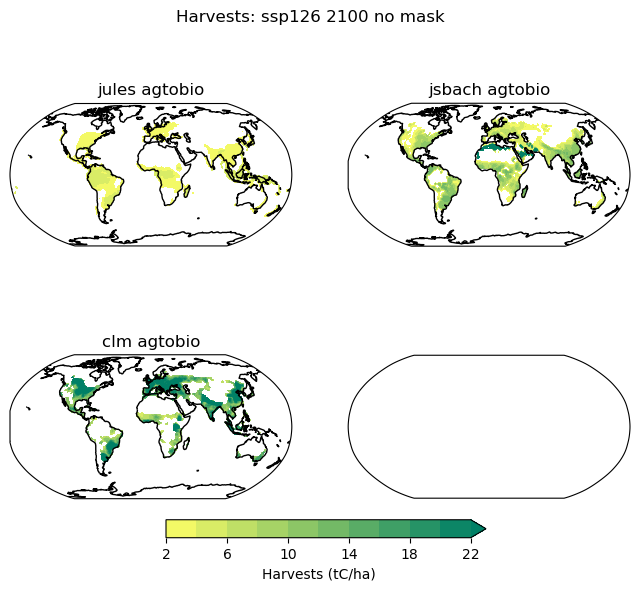

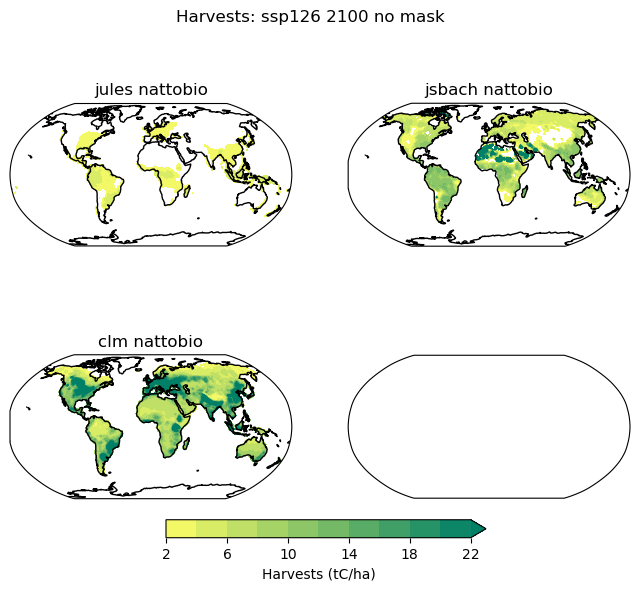

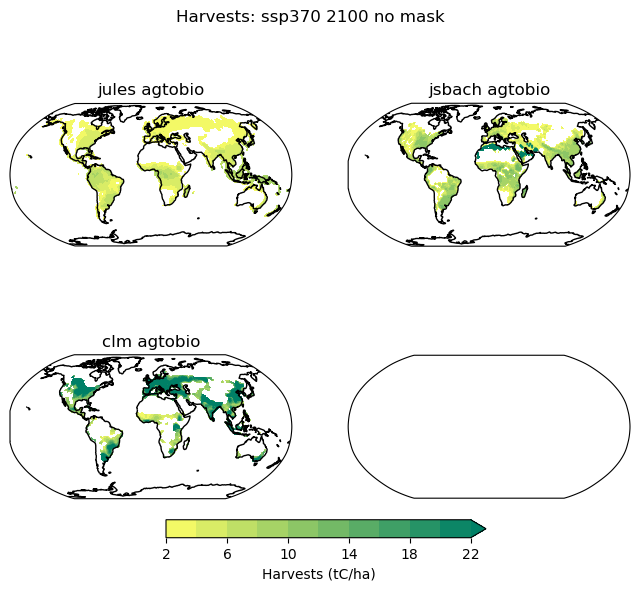

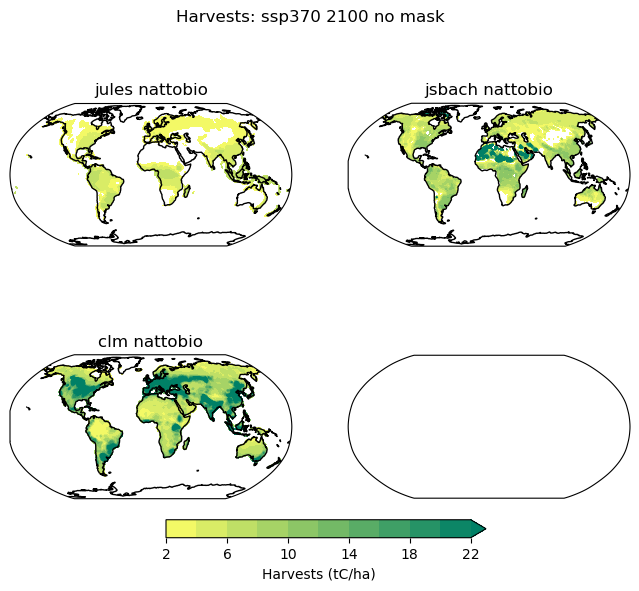

In [18]:
# MAIN CODE HERE:
# JULES      fBioHarvestpft - extract PFT 13
# JSBACH     cHbpharv
# CLM        fHarvest: loss from 1-yr crop product pool, kgC/m2/s
'''
Options: 
 plot_total means plot the cumulative total harvests in PgC. Problem with this is 
            that it will always show higher totals for nat to bio since bioenergy
            crops are placed in all natural land.
 plot_total=False means annual harvests are plotted in tC/ha.
 mask_value: 0 no mask
             1 Minimal constraints on bioenergy 
             2 Sustainability constraints on bioenergy
 map_year = The year of the maps in the LSM simulations
 be_threshold = mask values below this from the Magpie scenarios
'''

plot_total = False
mask_value = 0
endyear = 2100

be_threshold = 1.0e-9

MODELS=['jules','jsbach','clm']
LANDUSES=['noluc','agtobio','nattobio']
SSPS=['ssp126','ssp370']
ESMS=['mpi-esm1-2-hr','ukesm1-0-ll','ipsl-cm6a-lr']

years = np.arange(2015,2101)     
nyears = len(years)

landuse_exists = {lsm_mod: {landuse: [True] for landuse in LANDUSES} for lsm_mod in MODELS}

HARVEST_MAP = {lsm_mod: {landuse: {ssp: [] for ssp in SSPS} 
                  for landuse in LANDUSES} for lsm_mod in MODELS}

HARVEST_PLOT = {lsm_mod: {landuse: {ssp: [] for ssp in SSPS} 
                  for landuse in LANDUSES} for lsm_mod in MODELS}

test_mean={ssp: [] for ssp in SSPS}
colors = {model: [] for model in MODELS}
colors['jules'] = '#F97306'
colors['clm'] = '#C5C9C7'
colors['jsbach'] = '#D1B26F'
colors['orchidee'] = '#A9561E'
#https://matplotlib.org/stable/users/explain/colors/colors.html

linestyles = {ssp: [] for ssp in SSPS}
linestyles['ssp126'] = '-'
linestyles['ssp370'] = '--'

# set axes
#ax=axes
#if plot_total:
#    ax.set_ylabel('Cumulative harvests (PgC) ',fontsize=10)
#else:
#    ax.set_ylabel('Average harvests (tC/ha) ',fontsize=10)
#ax.set_xlim([2015,2100])
#ax.grid(True) 

for ssp in SSPS:
    
    for model in MODELS:
    #First get no land use change (noluc)
        if model=='jules':
            HARVEST_PLOT[model]['noluc'][ssp], HARVEST_MAP[model]['noluc'][ssp] = \
                    jules_harvest('nolucbio','fBioHarvestpft',ssp,ESMS,endyear,mask_value,be_threshold)
        elif model=='jsbach':
            HARVEST_PLOT[model]['noluc'][ssp], HARVEST_MAP[model]['noluc'][ssp] = \
                    jsbach_harvest('noluc','cHbpharv',ssp,ESMS,endyear,mask_value,be_threshold)
        elif model=='clm':
            HARVEST_PLOT[model]['noluc'][ssp], HARVEST_MAP[model]['noluc'][ssp] = \
                    clm_harvest('noluc','fHarvest',ssp,ESMS,endyear,mask_value,be_threshold)                
 
        #Next get land use change scenarios
        for landuse in LANDUSES[1:]:
            if (landuse_exists[model][landuse]):
                print('get data for',ssp,model,landuse)
                if model=='jules':
                    HARVEST_PLOT[model][landuse][ssp], HARVEST_MAP[model][landuse][ssp] = \
                            jules_harvest(landuse,'fBioHarvestpft',ssp,ESMS,endyear,mask_value,be_threshold)
                elif model=='jsbach':
                    HARVEST_PLOT[model][landuse][ssp], HARVEST_MAP[model][landuse][ssp] = \
                            jsbach_harvest(landuse,'cHbpharv',ssp,ESMS,endyear,mask_value,be_threshold)
                elif model=='clm':
                    HARVEST_PLOT[model][landuse][ssp], HARVEST_MAP[model][landuse][ssp] = \
                            clm_harvest(landuse,'fHarvest',ssp,ESMS,endyear,mask_value,be_threshold)  

    for landuse in LANDUSES[1:]:
        mp_fig,mp_axes=plt.subplots(nrows=2,ncols=2,
                                    subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                                    figsize=(8,6))       
        mp_axes=mp_axes.flatten()
        ax_ind=0     
        pltname='/bdd/ESM2025/WP10/maps/harvestmap_'+ssp+'_'+landuse+'_mask'+str(mask_value)+'_'+str(endyear)+'.png'

        for model in MODELS:
            print('make map for',ssp,landuse,model) 
            land_fraction,lons,lats = get_lsm_data(model)
            input_array = np.array(HARVEST_MAP[model][landuse][ssp])
            
            # FIRST MAP the harvests.
            cs = make_map(model,landuse,mp_axes,ax_ind,np.array(lons),np.array(lats),input_array)

            ax_ind+=1
        
        # Add a colorbar axis at the bottom of the graph
        cbar_ax = mp_fig.add_axes([0.32, 0.10, 0.4, 0.03])
        # Draw the colorbar
        cbar=mp_fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',
                                    label='Harvests (tC/ha)' )
        # Add a big title at the top
        print('save the plot:',pltname)
        if mask_value==0:
            plt.suptitle('Harvests: '+ssp+' '+str(endyear)+" no mask")
        elif mask_value==1:
            plt.suptitle('Harvests: '+ssp+' '+str(endyear)+" minimal mask")
        elif mask_value==2:
            plt.suptitle('Harvests: '+ssp+' '+str(endyear)+" sustainability constraints")

        plt.savefig(pltname,format="png", dpi=400)
        del(cs,mp_fig,mp_axes)
        del(input_array)

agtobio
jules agtobio
jules ssp126 2030s: 3.742135422080053 2050s: 3.784979437715785 2090s: 3.618488336403212
jules ssp370 2030s: 3.8202358846642626 2050s: 4.064569148038183 2090s: 4.436648415886288
jsbach agtobio
jsbach ssp126 2030s: 5.267968003378378 2050s: 5.319949279679188 2090s: 5.345823870347283
jsbach ssp370 2030s: 5.2150851069256605 2050s: 5.213758377919044 2090s: 5.187413906146548
clm agtobio
clm ssp126 2030s: 12.683640512303494 2050s: 12.484488171355371 2090s: 11.997146906130782
clm ssp370 2030s: 12.791863020383426 2050s: 12.803895575967834 2090s: 12.465972907786062
nattobio
jules nattobio
jules ssp126 2030s: 3.894335946149434 2050s: 3.9426012680890885 2090s: 3.7742536674936247
jules ssp370 2030s: 3.9794918113662328 2050s: 4.2672003234044995 2090s: 4.664204725270837
jsbach nattobio
jsbach ssp126 2030s: 4.103916831994621 2050s: 4.166580664999421 2090s: 4.207703825320385
jsbach ssp370 2030s: 4.074481138633154 2050s: 4.114673353808181 2090s: 4.096829591170968
clm nattobio
clm ss

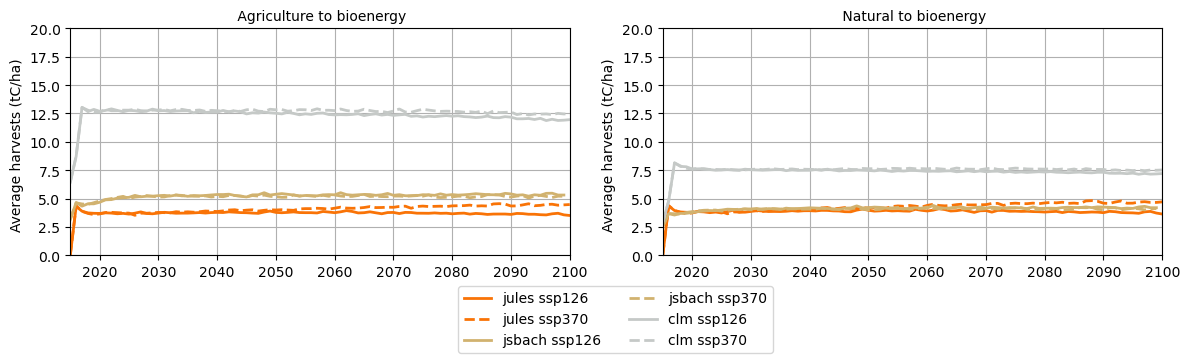

In [19]:
# PLOT THE LANDUSE SCENARIO DIFFERENCE FROM THE NOLUC SCENARIO

landuse_title=[' Agriculture to bioenergy', ' Natural to bioenergy']

plotdiff = False

ix=0    
fig2,axes2=plt.subplots(1,2, figsize=[12,3])

for landuse in LANDUSES[1:]:
    print(landuse)     
    
    # set axes
    ax=axes2[ix]
    ax.set_xlim([2015,2100])
    ax.grid(True) 
    
    if plotdiff:
        if plot_total:
            ax.set_ylabel('Cumulative harvests (Bio-noluc) (PgC)',fontsize=10)
        else:
            ax.set_ylabel('Average harvests (tC/ha) ',fontsize=10)                  
    else:
        if plot_total:
            ax.set_ylabel('Cumulative harvests (PgC) ',fontsize=10)
        else:
            ax.set_ylabel('Average harvests (tC/ha) ',fontsize=10)  
   
    for model in MODELS:
        if model=='jsbach':
            endyear=nyears-1
            totharvest = np.empty(nyears-1)
            totharvest_noluc = np.empty(nyears-1)

        else:
            endyear=nyears
            totharvest = np.empty(nyears)
            totharvest_noluc = np.empty(nyears)

                
        if (landuse_exists[model][landuse]):
            print(model,landuse)
            for ssp in SSPS:
                        
                if model=='jsbach':
                    if plot_total:
                        totharvest = HARVEST_PLOT[model][landuse][ssp]
                        totharvest_noluc = HARVEST_PLOT[model]['noluc'][ssp]
                    else:
                        for j in range(0,endyear-1):
                            totharvest[j]=HARVEST_PLOT[model][landuse][ssp][j+1]- \
                                              HARVEST_PLOT[model][landuse][ssp][j]
                            totharvest_noluc[j]=HARVEST_PLOT[model]['noluc'][ssp][j+1]- \
                                                    HARVEST_PLOT[model]['noluc'][ssp][j]
                            totharvest[endyear-1]=totharvest[endyear-2]                                
                            totharvest_noluc[endyear-1]=totharvest_noluc[endyear-2]                                
                else:
                    if plot_total:
                        totharvest = np.cumsum(HARVEST_PLOT[model][landuse][ssp])
                        totharvest_noluc = np.cumsum(HARVEST_PLOT[model]['noluc'][ssp])
                    else:
                        totharvest = HARVEST_PLOT[model][landuse][ssp]
                        totharvest_noluc = HARVEST_PLOT[model]['noluc'][ssp]
                                           
                if (plotdiff):
                    plot_luc=(totharvest)-(totharvest_noluc)
                else:
                    plot_luc=totharvest
                            
                ax.plot(years[:endyear], plot_luc[:endyear], label=model+' '+ssp,
                                    c=colors[model],ls=linestyles[ssp],lw=2)
                ax.set_title(landuse_title[ix],fontsize=10)
                ax.set_ylim(0,20)
                print(model,ssp,'2030s:',np.mean(totharvest[15:25]),
                              '2050s:',np.mean(totharvest[35:45]),
                              '2090s:',np.mean(totharvest[75:]))

                    #m,b = np.polyfit(years[endyear-20:endyear-1],plot_noluc[-20:-1], 1)
                    #print(var,model,ssp,'slope over last 20 years:',m)
    ix+=1

handles2,labels2 = ax.get_legend_handles_labels()
fig2.legend(handles2,labels2,ncol=2,loc='upper left',bbox_to_anchor=(0.38, 0.05),fontsize=10)
fig2.tight_layout()

if plotdiff:
    plt.savefig('/bdd/ESM2025/WP10/plots/fharvest_global-noluc_tC'+str(mask_value)+'.png', format="png")
else:
    plt.savefig('/bdd/ESM2025/WP10/plots/fharvest_global_tC'+str(mask_value)+'.png', format="png")
